### Libraries

In [32]:
import pandas as pd
import folium
import geopy.distance
import requests
import json 
from pandas.io.json import json_normalize
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import numpy as np
import os, base64, io
from folium.features import CustomIcon
import geopy.distance
from matplotlib.pyplot import figure

### Data

In [5]:
data = pd.read_csv('Denver_Crime_with_Address_Recent.csv')

data_crime = data[(data.OFFENSE_CATEGORY_ID=='drug-alcohol') & (~(data.OFFENSE_TYPE_ID.str.startswith('drug-marijuana-possess') |data.OFFENSE_TYPE_ID.str.startswith('drug-marijuana-sell') |
                                                                data.OFFENSE_TYPE_ID.str.startswith('drug-marijuana-cultivation')
                                                           ))]

data_clinics = pd.read_csv('SAMSHA_Colorado_Substance_Abuse_and_Mental_Health_Service_Providers_Denver.csv')

data_clinics_1 = data_clinics[((data_clinics.City=='Denver')| (data_clinics.City=='Aurora')) & (data_clinics.Type_.str.startswith ('Substance abuse treatment') | data_clinics.Type_.str.startswith ('Detox') )
                                                            & (~data_clinics['Opiod_Treatment_Settings'].astype(str).str.startswith('Does not treat opioid addiction'))   
                             ]
                             
    
census = pd.read_csv('census_neighborhood_demographics_2010.csv')

census_1 = census[['NBHD_ID', 'NBRHD_NAME', 'POPULATION_2010', 'PCT_HISPANIC', 'PCT_BLACK', 'PCT_WHITE',
             'PCT_OTHER_RACE', 'PCT_HISPANIC', 'OCCUPIED_HU', 'VACANT_HU', 'HOUSING_UNITS', 'OCCUPIED_HU',
                  'OWNED_W_MORTG_LOAN', 'OWNED_FREE_CLEAR', 'RENTED', 'MALE', 'FEMALE']]

naloxone = pd.read_excel('ArcGIS Naloxone Distribution  Centers - Data.xlsx', skipinitialspace=True)
naloxone.columns = naloxone.columns.str.strip()
naloxone_trimmed = naloxone.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
naloxone_trimmed['municipality']= naloxone_trimmed['municipality'].apply(lambda x: 'Denver' if x.lower()=='denver'else x)
naloxone_1 = naloxone_trimmed[(naloxone_trimmed.municipality=='Denver')]

string_object = open('Denver Statistical Neighborhoods.geojson', 'r').read()

### Convert Address to Lat and Long Using API

In [8]:
naloxone_1.head()

,objectid,name,municipality,phone,agencyurl,operdays,operhours,pocname,pocphone,pocemail,comments,x,y,fulladdr
18,24,Albertsons/Safeway Pharmacy,Denver,null,null,null,null,null,null,Lisa Raville,Albertsons/Safeway Pharmacy\r\r\n\r\r\n323 Sou...,-1.168731e+07,4.823972e+06,"323 South Broadway, Denver, CO, United States"
24,30,Albertsons/Safeway Pharmacy,Denver,null,null,null,null,null,null,Lisa Raville,Albertsons/Safeway Pharmacy\r\r\n\r\r\n1653 S ...,-1.168212e+07,4.820571e+06,"1653 S Colorado Blvd, Denver, CO, United States"
29,35,Albertsons/Safeway Pharmacy,Denver,null,null,null,null,null,null,Lisa Raville,Albertsons/Safeway Pharmacy \r\r\n\r\r\n2660 F...,-1.169126e+07,4.830456e+06,"2660 Federal Boulevard, Denver, CO, United States"
30,36,Albertsons/Safeway Pharmacy,Denver,null,null,null,null,null,null,Lisa Raville,Albertsons/Safeway Pharmacy\r\r\n\r\r\n6460 E ...,-1.167894e+07,4.817529e+06,"6460 E Yale Ave, Denver, CO, United States"
34,40,Albertsons/Safeway Pharmacy,Denver,null,null,null,null,null,null,Lisa Raville,Albertsons/Safeway Pharmacy \r\r\n\r\r\n2150 S...,-1.168544e+07,4.819181e+06,"2150 S Downing St, Denver, CO, United States"


In [9]:
mapquest_key = 'GEEAb28nEwLa40IsC7DPjmVhxztOnYOr'
prv_key ='QAa0JisnNEerXNLX'


lng_nal = []

lat_nal = []

def convert(address):
    converted = address.replace(" ", '+')
    converted = converted.replace("# ", "")
    converted = converted.replace("#","")
    return converted

clean_address = filter(lambda x:  x != 'None', naloxone_1['fulladdr'])

for address in clean_address:
    #print address
    clean = convert(address)
    results = requests.get('https://www.mapquestapi.com/geocoding/v1/address?key={}&inFormat=kvp&outFormat=json&location={}+Denver%2C+CO&thumbMaps=false'.format(mapquest_key,clean)
                      )
    results = results.json()
    lat_long = results['results'][0]['locations'][0]['displayLatLng']
    #print lat_long
    # append lat long to list
    lng_nal.append(lat_long['lng'])
    lat_nal.append(lat_long['lat'])
    

In [10]:
len(lng_nal)

89

### Coordinates

In [11]:
crime_lat = data_crime['GEO_LAT']
crime_lng = data_crime['GEO_LON']
#crime_test = data_crime[['GEO_LAT','GEO_LON']]
crime_lng_lat = [(ln,lt) for ln, lt in zip(crime_lng,crime_lat)]

clinic_lat = data_clinics_1['Y']
clinic_long = data_clinics_1['X']
clinic_lng_lat = [(ln,lt) for ln, lt in zip(clinic_long,clinic_lat)]

In [12]:
len(crime_lat)

1675

### Denver Neighborhood Polygons convert to df

In [23]:
json_object = json.loads(string_object)

df = json_normalize(json_object["features"])

In [24]:
coords = 'geometry.coordinates'

df2 = (df[coords].apply(lambda r: [(i[0][0],i[1][1]) for i in r[0]])
           .apply(pd.Series).stack()
           .reset_index(level=1).rename(columns={0:coords,"level_1":"point"})
           .join(df.drop(coords,1), how='left')).reset_index(level=0)

df2[['lat','long']] = df2[coords].apply(pd.Series)

### Update Neighborhoods with Crime Data

In [26]:
coord_dict ={}

crime_dict = {}

clinic_dict ={}

denver_neighberhoods = df['properties.nbhd_name'].unique()


# init dicts
for each in denver_neighberhoods:
    crime_dict[each]=0
    clinic_dict[each]=0
    coord_dict[each] = list(df['geometry.coordinates'][(df['properties.nbhd_name']==each)])[0][0][0]
    
def contains(list_of_coor, point):
    pnt,poly= Point(point),Polygon(list_of_coor)
    return poly.contains(pnt)

#test =[[-106.941313, 40.739151],[-105.041313, 39.739151], [-104.941313, 39.739151],[-105.041313, 39.739151]]

## Update Crime
for point in crime_lng_lat:
    for n in denver_neighberhoods:
        if contains(coord_dict[n], point):
            crime_dict[n] +=1
            break
            
# Update
clinic_to_neighborhood = []
for pnt in clinic_lng_lat:
    #print pnt
    for n in denver_neighberhoods:
        #print n
        if contains(coord_dict[n], pnt):
            clinic_dict[n] +=1
            clinic_to_neighborhood.append(n)
            break
    else: 
        clinic_to_neighborhood.append('None')

### Determine Cutoff Based on Distribution

In [27]:
crime_dict['Capitol Hill']

168

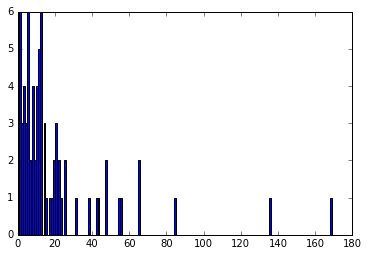

In [29]:
lst = crime_dict.values()

plt.hist(lst,bins=range(min(lst), max(lst) ))
plt.show()

# use 50 +, 25-50, 0-30

### Group Neighborhoods Based on Cutoffs

In [30]:
low = {k: v for k, v in crime_dict.iteritems() if v < 20}
mid = {k: v for k, v in crime_dict.iteritems() if v < 50 and v >= 20}
high ={k: v for k, v in crime_dict.iteritems() if v >= 50}

### Plot on Map

In [31]:
map = folium.Map(location=[39.7392, -104.9903], zoom_start=12)
fga = folium.FeatureGroup(name="Drug_Arrest")
fgm = folium.FeatureGroup(name = 'Drug Abuse Clinic')



# add crime points
for lt, lon in zip(crime_lat, crime_lng):
    fga.add_child(folium.CircleMarker([lt, lon], radius = 8,  popup = "Crime Arrest", color="red"))

# add clinics
for lt, lon in zip(clinic_lat, clinic_long):
    icon_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAyVBMVEX///8zMzM0NDTz8/P09PT+/v719fX4+Pj7+/v2UxQsLCwlJSVtbW3qUhcqKiro6Oh/f3/n5+dhYWHyUxVCQkL2TgD2UAtEREQgICBubm46OjpmZmb3bz/3cUT4hGYcHBze3t7Pz8+Dg4ONjY2vr6/2RgBTU1OXl5fraz52dnbpSwC7u7ulpaUTExPFxcWdnZ1YWFjsgGP8y7z5jWz929HvkHLpPwD4gFnxdEzqVh7W1tb47un5mn/94NbtmIH/9O/6sJvvq5fyjW6YN3V+AAAV1UlEQVR4nNVdC3vaOtK2MbKNTbglARdOCiQkadIkzbbd3W5Pz7bf+f8/6rNutmRpdDE26fI8LQoIS681oxm9M5KDgL4QUgoBVOi/breXI680pX8ioRA0C8heF8F1bZfzqevTTfZXwn6QVIWUf6MWOq7LOpI063bTNLt4nLIfxOyXMW8lTuQq2roBWBe6XNq8nE9dr26SCsmQ/RUP2Q+G7BJpxH/JCzGvO+R1o7hRJYlS77pV08ihaZ9uElHl96juiOGXEdTpVAUI1tUBtNZVLzdUm27WJTLLJbe+jdHpAdrrxs3RTh26SaSYzz1oGCkA7bfRIKI+nfZpuq4b2ABSWUQcoMet6QagRkS97q1zNxu/dBDu/xEdlAF6yUknADUi2kqcfUfQRbjfUAdbdJO1coyZOEoHXWymTkSdu0mmGZS8oR30GO1WALGlqH2g/nWwWaWlmXAfB2bxT2UmhsH0cP3u+rBLYVetUzNB3VVu8fs3E3FyXxSTbJLn9xxgv2aCVUEtxr4lwHERlq/BICzGQUtXrVU3+S89bk0bEY2TRc4AhmG+QEFvrpoWYP86GCebGmAJcRNXK5qedFAG2L8OxmMRIIbYAmCbbqIWt7ENQHkEcSHfkLo9uWo1QGLx4/5FdNEEiHWxP1etrkstfuIP0FNElRFkghr3ZSZ4XWrx074BJmMdQAxxGDTqHrWi1zSNv0GptZXOdZAXqC527qopl2v/y9Y6yAtYF3szE+0BdqGDlenfINSXDjYAnl5Euekfgp0+ykw0Ab6FiLLpZoGgpqMuiAfUM0DLCFLTj2xNH6GDjPM+laumL+Rj1JsOcovfE0CXEaS6mMSQiB5nJhJm8Vv8shsdrEz/olNXre6mZPFPbCbEAtfFjkRUHYd+AEKumg5gafrH4uWOctXUbra/NV3oIAVITH+i0UGl0z2OYF86OOCmf1ERb93GiFx/2Z8O8gLTxa5jRKgXgL4iSj8gK42OXLWqm7LFfzsR5QxcEHQcIyL2sMrYeKtJpv6gdMPjSkS70EFKX6TWTvfhqukA1gxcVzEiMcr9xjrIC5yB65Qba//LLnWQF7AudqSDrgD7NxMqA/cbAzxORLkudkrAt781fYgoLbBVf0frcmrxfXLVegdYMXCdAATy2k5vJhoM3Bh1RP7JeW2n0cHCDtDMwPl0s5HXdgoRzS6+X2RWgNRoOAI0dRPKa2szgm5mIruYBruLzArQiYFzHodOALqt6LP1tHQVd+vMoa6FgfPoZjcA3UYwjEino7Jkn5C0DFx3I9iPDk7Zdae1Lhp+lC+6WPR0MoLuOsh7NOe6aDQpIAPn0c1GXluvIjqoAQbpLsysANmq/ziAUl5bvyK6jsSJI4gGmRUgCdskx4ioktfWCqC3iNLLlbpoBEjf8wWnbVoBlPPa+nTVVIBEFx3cOoWB8+omqYJOrYPVdechZPolN3zTegR53fa/bKOD09UuYJdLpoDpb7jhOgauPcDezcQqX02ryxGjYV155Bs4r6hngB6uGh/BElKGIbLgSzmKDkurioFr002qxr3OoqEgokTzskEU8ODLNGyafj0Dh9qOIJlHUdynDgoiyvSu/GxXbTHkKw0TwAYD5wVQinL3r4N8vLLVnF5uGDMHzgwQrzR0DJwdoBTl7ttM8BHE32QXUcCJXyyoNoB6Bs6hm/gbJcrdl5mQNC4Lp9XlonUG4RIKbNXv1U1etw3Ao1cTpaBW+zyauqgvkOmmPcBeXDXRTKyac2bGTX8apfN1ZhRRZvolBq5XgK46GGl1kBewCPOmRV2EC6XpPxHA1mZCroLHmDc99WTg3AE2+fOezYRcF3s3vGk/Bs4dYDOvrTdXTV+3NP18Jk/mjgycJ8BGXlt3IirqYAZzMtil4z0iq36rMuYLvhXFLa+NDGFlEHvRQTPphGvyHrkycB4UI7X4yAOg/4peNRONuitvBm5sYeDApKHeXTV9IbuYV46xCwMX2hg4hSj3AXikq6YvZIM5bxo7cFaArgxcC4COZsJb7DK66u+LgfMYwQ5cNV2nB3TVz5qerk0MHP8AZOBUgMgdoL+rNnADSG5L2i0Dp49yn8RV03c6W+/YHR8mzEEwAnRl4JBzXluHrpq+05kDAyd/4MLAsTOI7HltrcyE0yRT956YftZ0Kd5WgGHIdNEI0DGvrZWZMLhqOoB01c+bVjVYdxWad2PQQZ6q2tkIescH5Q/MDJzuKni6MY3gULQXp3XV1BEkEDkDVzY9l0w/dJV8nIBMqAfAPlw1HcABW/XTpmUGDrpKxcAdJaL+OuhsB9Wr1AzctBUDVwMUo9ymvLbeXDX9N4SBo00fxcAh23lt/azobSNIIF4wN7z0caYWN5yZ/rHKwtRHbkhR7i6DLzaAcBXs9nGxi9wYuIXidFY7Gmx5bT27avoCYeCSmoGzXk5h4JrH3oB5bf27avpCqdPIg4EbNBk49dibo0W0Kx2sTf+8ZuBCCwM34KZfFdHICvAErpq+gG8aFzuy6rdermbg1F1Fx46gt5lwkVXOwKWBhYGrLscZOPWEQmip3JurZq0i3Dja17nT5EUZOOFkpliw+Eg9YaSj4Eu7EcT/Z+t5dVwuyMBJl8O6qNn41ji95U3NhFwoIdLOxFEAmP7G/cIM3LAJEMhr681MuCOVGbi5joFTLleu+puWT5/X1p+rZq0i1SXTDczAae4XOwymeRQxm1KP08EjXTV93dJowDlwWoEgq371ZKbjdbA7MyG/Gxg44HKEgWvu7DteBz1W9Bl9uQE0MHDg/cKBcNsI9rKiL3+RF9vt+m4zfni3uVtviyJ3IX6JG84ZuDCzAtQwcKidiPoFX7I8Xz0c9ng8OHWyezk8rPJcO0WKH0gM3Lq6KQaJpysNKK+tlxV9ni+emD7V3jFpcfe0yHMjQC0DZ1FpPIrQ6S09BF+y7frTjiuEuhci3n1ab82sGvVR6ahMqRtumbNEBk4+vaX74EtW3L2UA2Ym1V/uCmOmCdZ5gYFzmJTLlQaHJOW1de+qFXcfdTSY4ud/vCuMLR7NwPnpoLOrNskPqRPANIkPk4mh6WMZOE8RdXTVwu2mzrIwAyRpX5utoemKgSt9nKllKwoz/ZuGxe98RZ/lh8ANIK9y4LOq9nJ01U8ZuIEfA+c3gq6uWrb+7gkwCPbrCdw0GUUfBo7rIrP4Q0cz4eqq5a+RI0CBzA2i1xzug8TArSF/SLA6g/wdaYBy3uimMP9A1UHTLJqPUwBghUub0pyOC7gPpRvOrY4jA1fclNelFh/tn10AugZf8ocAAJj8/PXl6v2vn0lTRPkq6SGHO03tIr3c1ImBe96nPMp95zA9Sa6aUUTHIMDPy9vL5eXt42cAYMC0Rd9pOqPSunMXBi67SxjnTYbQOoKOOjh5hUQ0+Xy7HI1G52fnt59VESV14+R1AneazgNWBq72erZ7et3gwZ726Oyq0X0GWh38uaQAz0bL5U/dCOK6Q9NWqGzAGTjEddEEcJA9MIQOI+jqqoXFDgA4DH7dMoCj0e0vAGA5UWpmm6rTnIFD8ZA5HCaA5T965V3emZkYbA2G/v0lBzi6fA9nXh+2plEhq37KbDswcDm538G+sAEUgi+RcT04eQcDDK6WHOBoeTWEAKJkPDF0Gt9sTvzilYYRYFjsicV/KTzMhHlFT8KbkKG/WnKAo9EHOPM6mQ5Mnc6yacKTEOZN099cWhUvDKEZ4MqZFy0OBoAlQg7w/OwDCLCseygMncar/oDfjLmFgSteSMt7yAZ56mBpf0wAg6vzCuD5HwaAAbbPYKcFBi5GdBThujkxF2hqWnGJrlpkYdWe9yaA6MN5BXD5hwlgaaANADkDR4lfIwMXZmSLHDK5ND7Bl+zV6GwPPyw5wBFBaDjL4tXMqmGInNk2MXBEqPDrKXfSQRvxu30xAkyulhwgQWg6CeFlawJItoW5MHD5E0MYPYOzqAfA8oaZl0tXSw4QIzQmJqO7xgzSbNGNgduyJxMEwb3epRddtchK/BYHZARIEFKAJUJL5vXBdpwUXfXTZVgEMHDFJw4wiFaZ5lqSDjoEX+aWA3OIxaezzfLD0AiwnEDMADkDV/VONyHdpVVeW/JdQyB4Bl+yTWpZ0WOLz6fTD7bE5LF1t56VgZvseHQU71bdPzdd+snA1VWj7/nBlmx8NaoAnl1Z6gYfcwtAIRBe+jjTQZOOzLDtEvPadhel/y1coljEXgHQMJ/bOv3hvAI4+sNSN90Z3RBaEBm4eCGvSXLs+chR7ug6ry6aFYOnwEdEy5uzsgFMFYtvYuCClcN2RJGBC54GVcAuzPObuLocz2uL0/n9xXOR53nxfPcUeQIcTG5sABWLb6YYb0wsOC+IDByaPt09bwvc/4t7MtFy4ot+zXygl8PTYS+t0m2uGn0fFB8tAKOmxbdwqB8LO0DCwInqH+0/Hg4f5xySCJAHvwOep+ObJ7PdSQD5JMcvh0plly1+/TzuNJB/RJvemWj+umniowpNB3xGTxsAQSp61gxh6gGGWyQCTP/89eV9+frHP96/p+9l4bwCWL7zb6oqf//fn1LTaBs6ACw9s5leeKqbbAGIZhOHVsr/L6RF7K/l7WX5eny8JK8lKQgAR2ePS/oVr1IWlr+kpi9CF4DhZKYFGMl5bfCjwdKZIZggvGcLCeAtZ9WquUUunNUF/s3ZaHn7S2g6XbhQ9yFBaD+9BQQYBdd6/rIxgmH2kNZpj3/djloAxBTcXzVBlTzYd8ziQokQHkHbeW34l9fmSZs7j5Pr+pzX4O/LdgBHl3/XO+epubA3PZkhUAdTFuU2ASQI7QBDZg5pK+fLdgDLgjD13xsiUeK9naUNgOpjMUwAMUIHgIPJfd0KumwN8DGtm74H1+VS09lMuLeyDjoBLBHaJpmwdmlYK8u2AM+XrA+46XsTUV3fW4ZQI6JuADFCeysDKqW8lX9ftgR4+e8aYKmHLgAHxFq0H8HS4juEeNicXbXy9V/tAI5uvwpNz1yOVWT20KCDjbw2hYZIQYvfcIE3IpH0z9t2AP+uRzAINi3urTqC1qeSgRa/yTGsAvERRj9uL5feInr7A4kM3MoJIEZo0EHbU8lgi6/y57Jj9PXL+ZI7ZI/MQ1uKAAVvjhZGX74KI4jioSEaLH5QIjTkP9ieShYhwOKrcwBZW4itIL524AY3+FYDXF7JVRLUaDqO589uwlPaQxigy1PJtBZfQ4MVL3IrmgDoh1E1gmQFbNykzOJF9qZLhHAGi5Q0BHCdOouvpZfvLa3EMV0BEx3ECE0AQZdGsz+aWXzD46EggDRIp7H4WjNFQgSmEYwQRUjmFrwCtuyjvzPE88VvuMWHH01jHMESoSbMqgEYhnlkAUjX+HTyXP5hAoibHup8Np3wUIuvEx43gKrFhxyNUhFNAFPK6tdRbss++hdTwoL4DUFoEFEkfazs9U4Viw9y7ZOHFNZBUigR1lFuow7iO6vTDl3TGKFhBKGnklVbwND1xKEV8mKUEJhGoo9ya3UQM3wKSwM0jS0+DJDltZliCLLFh33hkPGJMEBtlFsVUdr0RyV7Arq3JUIDQMvpLVi4JYtvjndtGq00r1tz3mc8yq3XwfK1UNUf0o6ZRju4ZOhPb5F3KYoW3xLvwm6N6ZkvFed9xqPcgIgGwX7rCrC0h5woVQFKFh+iqwSLbxJRsr54ZwI4jDnnfcaj3BBAlI5ddqpxhO0BNiy+faPD885wxmQV5WYWHxZRlHx/dgbILb4/QE7zX7vsb+ACswlAgEPEotyVxQfMBF6ybZrn7xj6wC2+K0BlM/vMnPchF5j7DcTotXltGvVPWZKWm/BQiw8CtJ3ektYrYJehzFYJDFDMaztv5rWJZ1nEq0YihrFpavFBgMDpLbUPVNlDN1nNbwx5Moa8NvGggOBG2jdga7pEaAAoP5UsHjZEFP+S2UNXZdzuEQQw+FZb/MdvDYD1LmxmKZznN2zxYZJCPr1F+yRlag/dZ5t8DiUsoP8+1pzMD7kjQtOR1wgSiw/TTNDpLeJCy8h5a9z/7BXpAabx15qBu/0r0OtggBbydkTrvc1mPNIKL5DkjjTWIdgeuo9g+Q5FLMvh+XHLAf4IAB2kEVkPgJXFtwEEn6QsWnwXgHSrCuAhfbldEtrwCySiwY0xedZg8Z1HUHHTrx1SaRod2d6nkPn5/O0/j+ffPoMA759DT4DM4ltHsOnJ1KT/zBqJVf3WQgy1yTcu+fPPn7RHiogOS4Bbb4DU4hvydslck4AAE3uUWwXIswccTogVz5Mp76a3iDKLbwAoPZVMR1dZo9w6gKXNeI1MALUiOnz1nWS4xTektTaj3Bo+zhLl1gPEqan71OEAVcFM7AeeZkK1+BoLlfBxDEC6yhzlhgCGWBlTO8BqNZHeF/LlnCfw2uJrJnCamQOLqLvF13wT5qu9BWB1Ml6wX3l6MoLF57u34JQT+a+mF2uKcpsAloXsebwLlPNFVcoi+T7e+qwm5Ka5xbcDBDhxQ5TbAhDf3+3su01Eg++zrceCV2ma2kMrQJgyhqPcdoBlYZKP8cYczYqeAkQvm9yVc9Y3PYG9RPoJ/RiMajjltRk7khXr65fqpI86EoX/39+sC2faEGgazGtjAIjFNzyP3jWvzViYFMW7p315TR6rDOJptH96t91OXJltuGm/vDZ1oeWQ1+bQkUGY5dtitXi4vv/09On+5mGxKra5Y/jM0jSQ18YAsig3DNAhr80JIH1l2STHr0kGObt+ABlCNa+tPjMJf8MlByA7bHlt7gA7r0vf1bw2zYkUBoC2vLY3B2jIa3MD6JrXdnqAvKDktXkCNOe1vSHA6gMor80VoDGv7XcA2Mhr02SqmwE657WdGKBQV5/XBkS5/fLa3hCg+IGU16YCtOS1DYdwXtsbApTq6vLagCi3ngtwzWt7K4C6vLYa4BF5bW8IsPFBpuS1qbkSJoBAXtvvA1CIcrcD6JzXdiqASt3J9XEAg4Oyzfu3GsHBgJzFcQRAtLMdv/m2IzgIi7kZIDIDTCPEtuf9FgA13+QzM0Aor02Yf9FdbmvlLQHeISNAp6eSJbNyOf57vvLtLDEDdHwq2ff7hzF+vRtv2Dt76QqbsXfdsVD3nflyUt2HTzuziLo+lYwHIOqtu5xHD5KqwPW6Ou+ff2OqC1+uWRdu2pKYXL8sO6vlX8JPT9LUrYMvrC6cOQFuDGnXtFPinumXTvFBe4/gTcqGm9EhwFZPM1eDL5EHQDghtg+ArUYQSFV9E4DWp5J1JKJg1MCwSfk4gI5PJTtSRFWAp9bBRl5bNwCPElHDzpdWAG1PJTsOoNrpk+ug7alk/+tmwpYVdSTAqIUOdj2CclYU7whfZ9QUIz/4P6me+2WtW1VR6yamuh00HSTNpulfPIRYMYtp7RBKbrpTXaTUTZW6iaZuB02rdelfPISI+DqjKqR1AQF1jVV86vo37VIX1f8LBaQpBEDBoa6uSl911W7+P2vyQaHxQm3wAAAAAElFTkSuQmCC'
    icon_a = CustomIcon(
    icon_url,
    icon_size=(15, 15),
    )
    fgm.add_child(folium.Marker([lt, lon], popup= 'Drug Abuse Clinic', icon = icon_a ))

# add naloxone
for lt, lon in zip(lat_nal, lng_nal):
    icon2_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAhFBMVEX///8AAADl5eXy8vLo6Oji4uLX19fe3t7T09PLy8vOzs739/f6+vq8vLxMTEzn5+dAQECIiIjFxcWgoKDu7u47OztWVlanp6cUFBQwMDBHR0eRkZFubm6ZmZmxsbFfX18nJycbGxsiIiJ6enotLS1+fn4MDAyurq5UVFRwcHBnZ2eEhIQlYOEFAAAGuklEQVR4nO2d7VriMBBGG0E+BEWUFYRVkXVd173/+1vSptC0M21aqck79PwSW3zmmALNZDJEUUeHBEY93xG0zED98h1CuwyVUgPfQbSJFlQ/fEfRIrGgUkvfcbSGEVQXvgNpi0sj2PcdSFt0guhcGMGZ70DaQrzgzP1ddD5tP5zTU0dQPbcfz8lJBe+qT50r9dh+QKemr1Iq70g3+5PW3xHTSTkKVo6iFrz5nqhOSFZQqT9lp2IKLpTNE38q5iWaF1TqN3eqFEGlPulTn8QIMi81LXj73fF9mR4puP/EK962gAq+M4Zqtcidei9McM+ldaoWxMvecJeoYZQ5FXQEV+WG6vpwqhZUHkNtRir4wiumGbdl/AgtTzx5T6/FB15xE5+6NI/+eg65HpPXJOqr/c+3vKIet6X1CIWsYBS98YovGUGkUUwFx+ZhyafGo/Xop9+4nentLEHu3o0CRPEpJ3hMlYpRnN2o3Gx+4KzITDyC4zqfrrgTp1jgWb7istrN8OI71KZs5I/iL/mj+Clf8Ua+4g/xitOts+KD71gbUpHakKC4KEtPiVB0v31T6sN3sE2oIwipWE8QcKmtriDcUs24tiDYKNYXfMYaxfqCg7iYESbdf9VAMKnXBBnFZoJJEgtiFGPBy5L0dwGzNjXXPwMsvI10nP3SDH+JIMAopoLuisl6QCoY/CjGgqbs0k3RCGZSO0ErxungQ1Xi2kHQpMut3FXAiragiyIlGLBiXrBa0Qg+5X8faFVmLGgXXlQkpMx6QEGQLMPxz5AQLFfkBYNUHJGCZYolI7hS6i04xfGLUkPqwAcjaEpQ7otHXqe6UDU8xahPCnKKu0SAEFxNkh0NASpy0IorvcGUGsGJfk5/dfgnIEAX2uwViXW4ldlZq/8t24nfuGtAK26JEVRGMHmD2qErFnm3BNNLFoKSojdC8PjKlaZoBLMjLkvRlBPb770rQYpGMP+aXeH0LahQXHBnASmWru6zgsc3IABKFM2eYXqcJSj2+ePrrQTFK/7oY7LXAUfxJ60YvwppQbOdI78zJVx4RepIMtfvvUEp/mUUqd+/meesD+MMAaNICZoZ4uNhnEFwVdwawUN9FY6iW+3iLi+I1GnDRTGd/loVcpIUU8HcAg+O4u8KwVdaEKmhSLliKkisfOA0ZipTTCdM5NIOjuI/VvCdH0EZiq+5jFuGdU9X5hLrI4EyLypozEyDyJXfRtFEhGIsQAjGi8PTNyGKnKDZAsgsAwUIozgk0hlGcJrsVMVRdN5CZBb3D5sAxCmmgse9xsIUc1NFeYrpZN/eL43TAJYsx6gaQVGKhcm+NEVisi9LkZzsHxiV/92AoBb1Y9i58J53CYrpa5AS3MTjCq+YvNIowXmUXLpXfuOuAbPNXY8RNReex09ay1CkBP8lz4n3BsArUgWOpmWh6cMxLv+7AeHcj8EWRFL800xQnKJpNGW1inFo7BsIDopGcGj/Fkexsv0LLZjtfBc6FYqmUVhBUIyiEaQ6UrFNb8OjRLFEEGiNWLefYjAtwkhBnD53GkbRNEKZkQdxVmxiGMX4I+GCPATXBoZXpEcQKKGRwiiOmdaFUB0LDIwi0xUG58Y0A/uOShDonsUqajQQwbmfsXFWXPmOtDGuiqXfNRE2jm1EfIf5FZwUsb/BzkXRXKRAkwsLF8V4EG9hm2m6NIRZasEd0vzJwknxA6aFD4VrWx/Em1PDyFERbgp1xFURa6JvQSoSJVVz34E2p9gMfTOhEjYl36QVOjnFp3h1mFAEvkcdFPwiMmmDOpOKMor3mV8Sm/0h5/sJiaJ1n012M8DLSh0Y5ucRTLsGsNxpltymGbbDD+wdap6lmtFVKkCdCiroces4W9+RnRJ6Ahls27cm0N/9Athgmodeq0Gd8ZP0XilFpC8Hq2RKlp8CTzQIyI/G++rnAUG2pED8dnMectMmTkcNF6idG8A34RREbSPwZJGkuKgq670mIjKrqGsZPPl6N1G3pwn9XCmDuMs0iiY7WxGn04Q79u4MgddpPnsDnCPmuV7OP4/34ji7TWsySYdy5zuS9khvAGTNoix6DyLvTi2STBxuzZQDyTCKSmgUiIcReLXGgZ7uI4Kzha8RS/mKz+ehKPu1GH/6d4roaEWcXYqN6BQlcHceitKSxDk6RQmcgeK4UxTAGSjqJSpZC+AFOkUJjM5DEbjq3YUzUBychyL2/tNKOkUJDGSWa2QZdooCOBNFkSUpRy47RQGcgaLelLLxHUS7dIoSmMlX7MsugdN0ihJYyC9nWEjP3ESRmE3gHR0dHf75D4seVJ5CB7xjAAAAAElFTkSuQmCC'
    icon_b = CustomIcon(
    icon2_url,
    icon_size=(15, 15),
    )
    fgm.add_child(folium.Marker([lt, lon], popup= 'Naloxone', icon = icon_b ))

    
#add neighborhoods
fgn = folium.FeatureGroup(name = 'Neighborhoods')

fgn.add_child(folium.GeoJson(data= open('Denver Statistical Neighborhoods.geojson', 'r').read(),
                            style_function=lambda x: {'fillColor':'red' if x['properties']['nbhd_name']in high
                            else 'orange' if x['properties']['nbhd_name']in mid
                            else 'green'}))


map.add_child(fga)
map.add_child(fgn)
map.add_child(fgm)
map.add_child(folium.LayerControl())
map.save("Map_Drug_Final.html")

### Combine Datasets with Census

In [539]:
crime_df = pd.DataFrame.from_dict(data=crime_dict, orient='index')
crime_df['drug_crime_values']= crime_df[0] 
clinic_df = pd.DataFrame.from_dict(data=clinic_dict, orient='index')
clinic_df['clinic_count_values'] = clinic_df[0]


In [543]:
combined = census_1.set_index('NBRHD_NAME').join(crime_df)
combined_1 = combined.join(clinic_df, lsuffix='_combined', rsuffix='_clinic_df')
combined_2 =  combined_1.loc[:, combined_1.columns != '0_combined' ]
combined_2 = combined_2.drop('0_clinic_df', axis=1)
combined_2.to_csv(index_label = "Denver_Neighborhoods", path_or_buf='combined_2.csv')

In [541]:
pd.to_csv

,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,...,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area,drug_crime_values,clinic_count_values
NBRHD_NAME,,,,,,,,,,,,,,,,,,,,,
Hampden,32,17547,2505,11750,1963,64,726,20,38,481,...,700,304,253,285,200,229,0.200466,0.000768,12.0,2.0
Baker,3,4879,1664,2854,144,43,52,10,7,105,...,231,113,64,82,23,7,0.101767,0.000406,20.0,1.0
Washington Park,70,6905,295,6356,28,9,119,3,13,82,...,70,31,36,27,6,21,0.090445,0.000411,1.0,0.0
Cherry Creek,13,5589,332,4896,79,17,168,4,3,90,...,211,79,92,161,224,207,0.063923,0.000228,12.0,0.0
Country Club,22,3001,94,2740,20,8,77,1,5,56,...,34,14,17,9,4,2,0.052865,0.000177,1.0,0.0


### Average Distance to Rehab Clinic

In [906]:
distance_dict = {}

at_risk_neighborhoods = {key for key in mid.iterkeys()}
at_risk_neighborhoods.update(high)

def search(data):
    for n in at_risk_neighborhoods:
        if contains(coord_dict[n], data):
            return n, coord_dict[n]
            break

def convert (point_1, point_2):
    return geopy.distance.vincenty(point_1[::-1], point_2[::-1]).miles

def average_distance (num, coord):
    lng = np.array([each[0] for each in coord])
    lat =  np.array([each[1] for each in coord])
    #lng_err = abs (num[0] - lng)
    #lat_err = abs (num[1] - lat)
    error = np.array([convert(num, each) for each in coord])
    #lng_avg = sum (lng_err) / len(lng_err) 
    #lat_avg = sum (lat_err) / len(lat_err) 
    return sum(error)/len(error) # need to check to confirm this is right


def search_closest_neighborhood (point):
    #n_dict = {}
    lst_test = []
    for n in clinic_to_neighborhood:
        #n_dict[n] = average_distance(point, coord_dict[n])
        lst_test.append(average_distance(point, coord_dict[n]))
    minimum_indx = np.argmin (np.array(lst_test))
    minim = np.min(np.array(lst_test))
    return clinic_to_neighborhood[minimum_indx],minimum_indx,  minim, lst_test

def search_closest_point (neighborhood):
    lst_test =[]
    for point in clinic_lng_lat:
        lst_test.append(average_distance(point, coord_dict[neighborhood]))
    minimum_indx = np.argmin (np.array(lst_test))
    minim = np.min(np.array(lst_test))
    return clinic_to_neighborhood[minimum_indx],minimum_indx,  minim, lst_test     



# iterate through all clinics
for pnt in clinic_lng_lat:
    if type (search(pnt))==tuple:
        distance_dict[search(pnt)[0]] =  average_distance(pnt,search(pnt)[1])
print distance_dict

# for those neighborhoods that don't have clinics
print '--------------------'
for neigh in at_risk_neighborhoods:
    if neigh not in distance_dict:
        distance_dict[neigh] = search_closest_point(neigh)[2]
        print neigh, search_closest_point(neigh)[0:3]

 {u'Civic Center': 0.34940874794651366, u'Capitol Hill': 0.6011255505811838, u'Stapleton': 2.24389865997737, u'Sunnyside': 0.8839035658616471, u'Baker': 1.0073104654654035, u'Cheesman Park': 0.5229273560665237, u'Five Points': 0.9213597169431318, u'West Colfax': 1.0925577540884945, u'Ruby Hill': 1.1867459010698984, u'Westwood': 0.7157177821892106, u'Washington Virginia Vale': 0.7806079054314923}
--------------------
City Park West (u'Cheesman Park', 13, 0.5184938040485806) 6.863163507010476
Lincoln Park (u'Civic Center', 42, 0.7134615989095179) 8.863228309699371
Jefferson Park (u'West Colfax', 28, 0.6412367000097997) 9.393857657890285
Athmar Park (u'Baker', 21, 1.4291731842303006) 9.806165477198128
North Capitol Hill (u'Five Points', 52, 0.5645942360211532) 7.633298757050895
Mar Lee (u'Ruby Hill', 3, 0.8835347056932201) 11.779294886347973
Villa Park (u'Sun Valley', 38, 0.9510486848247609) 10.820956868383591
CBD (u'Civic Center', 42, 0.6510274088287111) 8.310290858585297
Barnum (u'Westw

In [907]:
clinic_lng_lat[35]

(-104.843365, 39.772209000000004)

### Convert to Distance

In [875]:
coords_1 = ( 39.734123150387276, -105.03749867327836)
coords_2 = (39.700074, -104.9110931380000001)

print geopy.distance.vincenty(coords_1, coords_2).miles

0.138307386525


In [897]:
pd.DataFrame.from_dict(distance_dict, orient='index')

,0
Sunnyside,0.883904
Cheesman Park,0.522927
Ruby Hill,1.186746
Jefferson Park,0.641237
Villa Park,0.951049
Barnum,1.198883
Montbello,1.414682
Stapleton,2.243899
East Colfax,1.140995
Five Points,0.921360


### Plot Neighborhoods by Distance

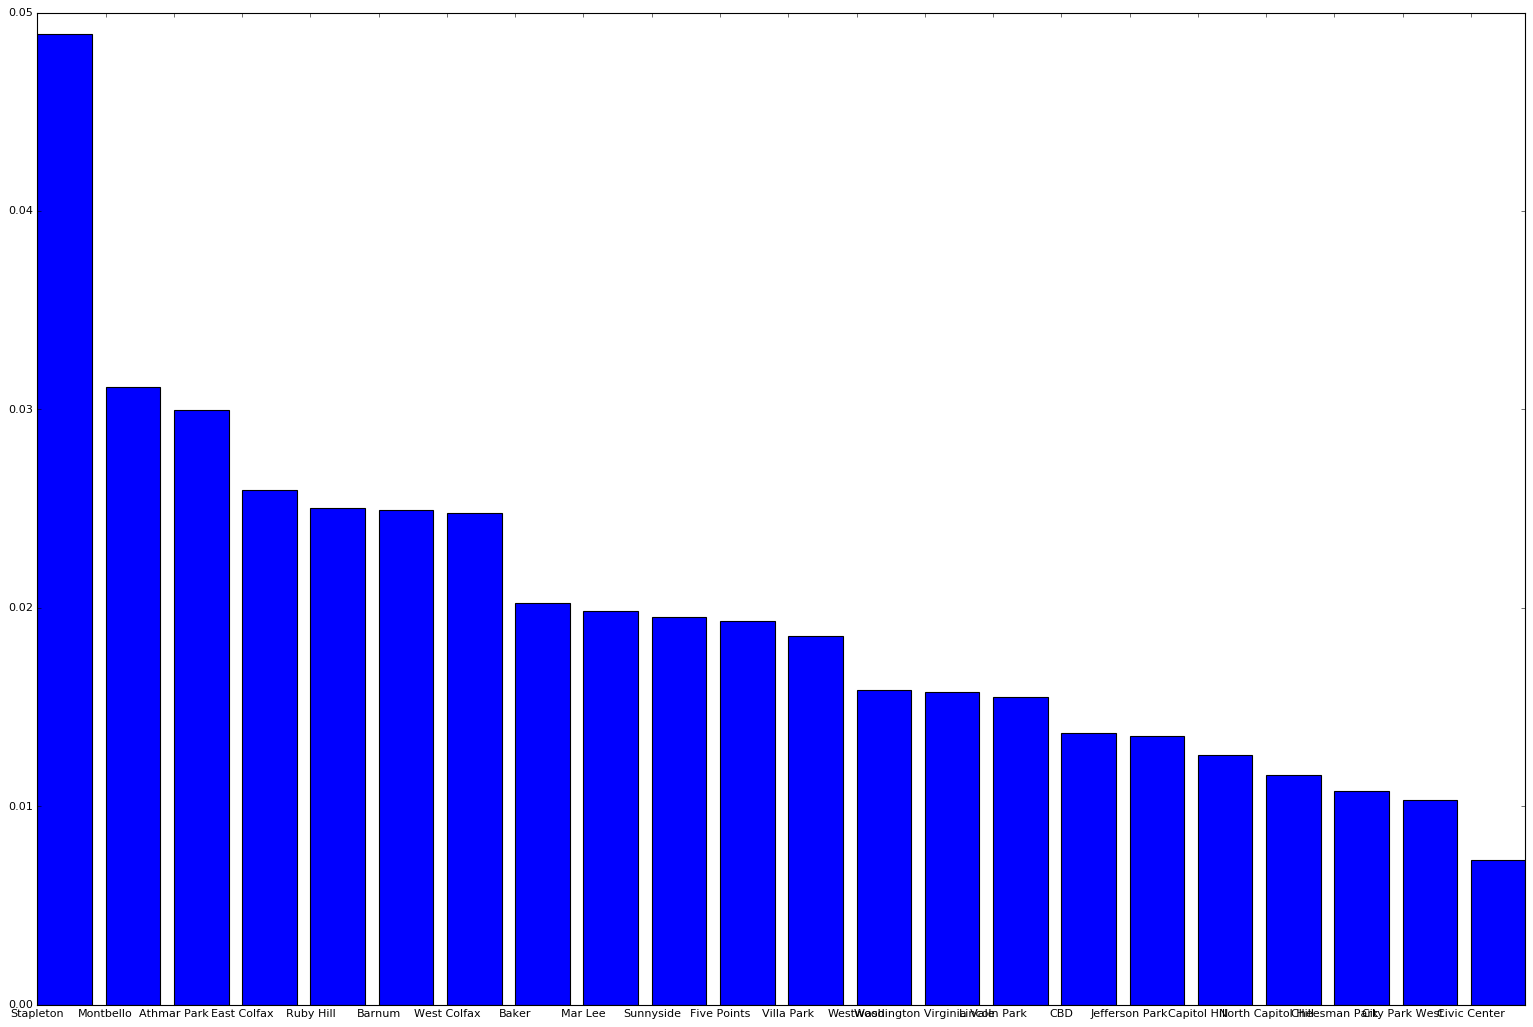

In [865]:
sort = sorted(distance_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
#sort = sorted ({key = lambda(k,v):(v, k) for key, val in distance_dict.iteritems()})

x, y = zip(*sort)

#ax.set_xticklabels(x, rotation=45, rotation_mode="anchor")
#ax.set_xticklabels(xlabels, rotation=45, rotation_mode="anchor")

figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')
# locs, labels = plt.xticks() 
# xticks(ticks, [labels])
plt.bar(range(len(x)), y , align='edge', orientation= 'vertical')  
plt.xticks(range(len(x)), x) 
plt.autoscale()

plt.show()